In [1]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df = pd.read_csv("processed/5.csv")
df.head()

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id,review_th,i,delta_t_f,t_bin,t_history,r_history,t_f_history,y
0,0,868,4,0,6486,-1,-1,5,7026,1,-1.00s,1.00,NaN,NaN,NaN,1
1,1,870,3,0,9000,-1,-1,5,7259,1,-1.00s,1.00,NaN,NaN,NaN,1
2,1,870,4,1,4000,0,734,5,7289,2,12.23min,597.63,-1,3,-1.00s,1
3,2,870,4,0,3000,-1,-1,5,7299,1,-1.00s,1.00,NaN,NaN,NaN,1
4,3,870,3,0,4000,-1,-1,5,7339,1,-1.00s,1.00,NaN,NaN,NaN,1


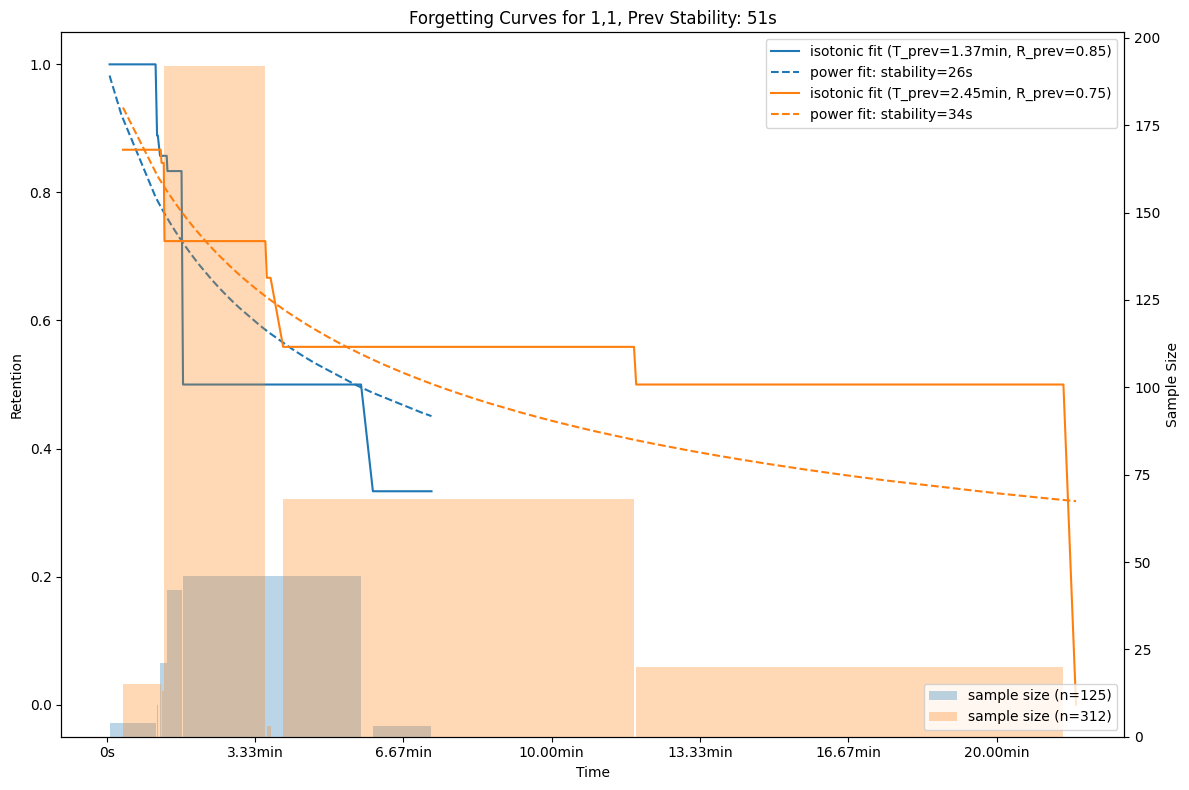

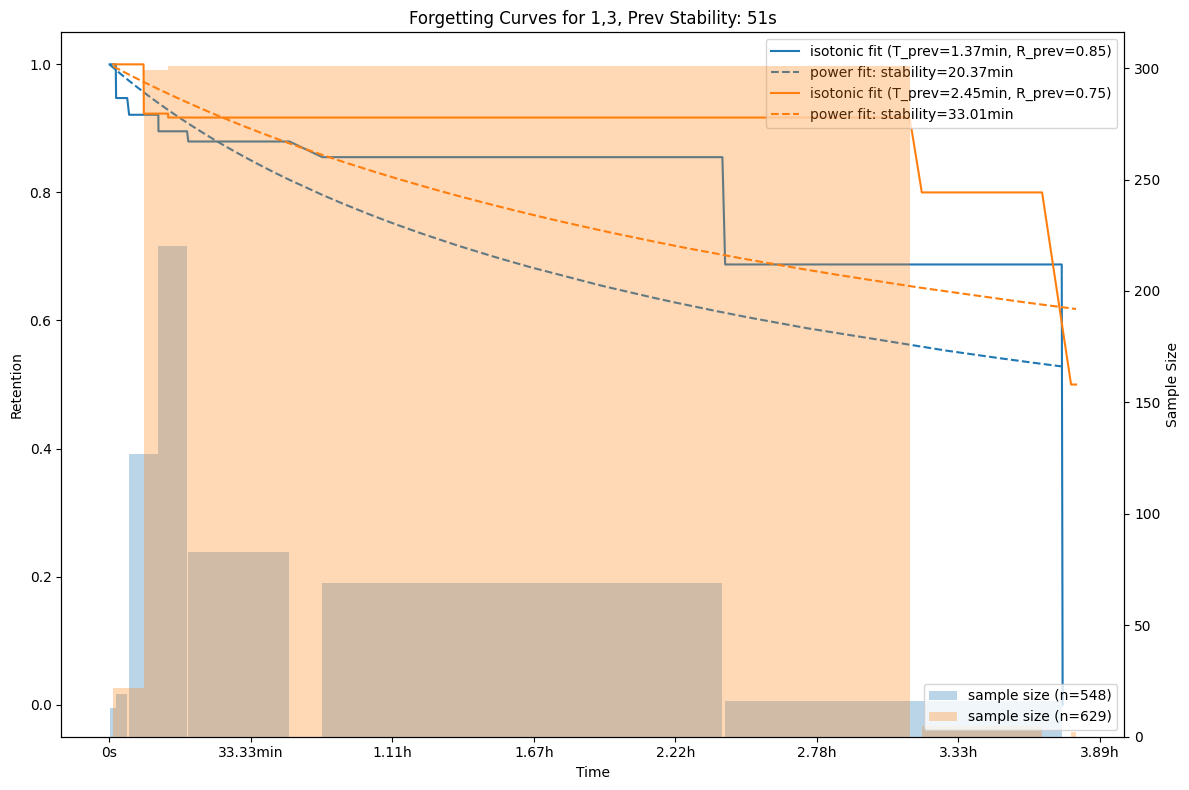

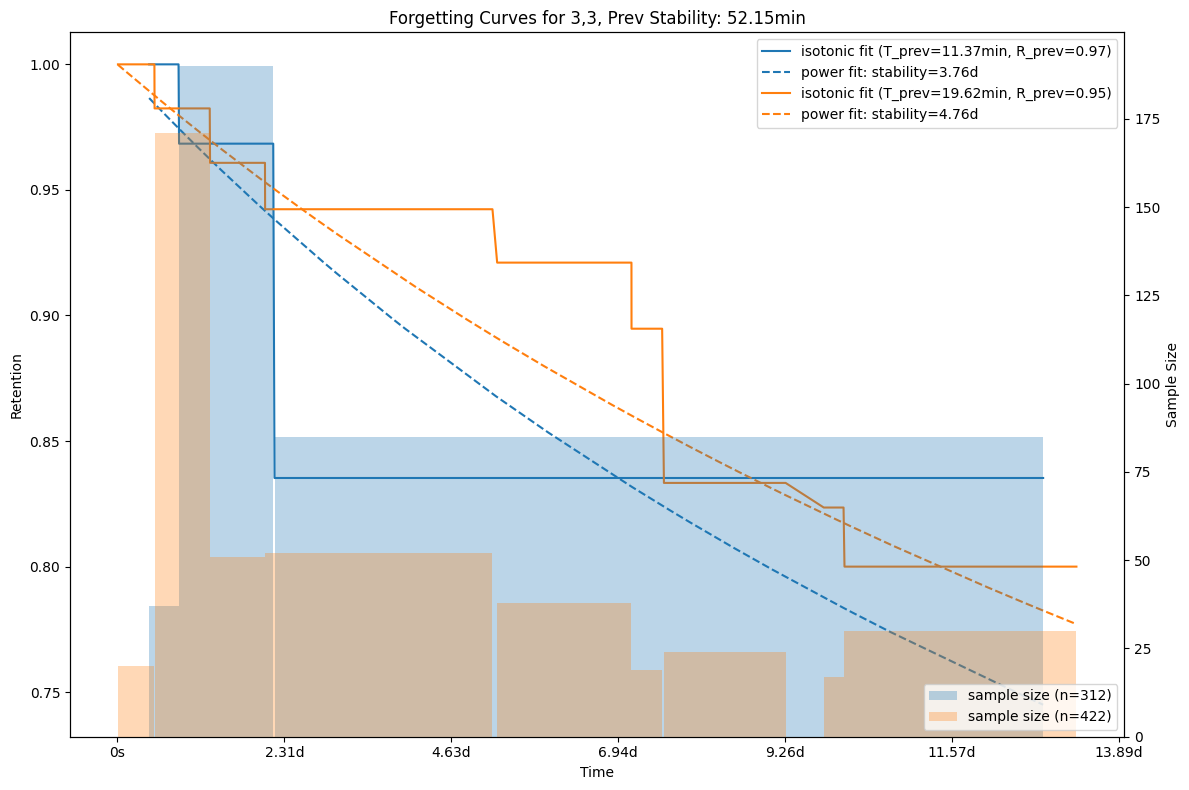

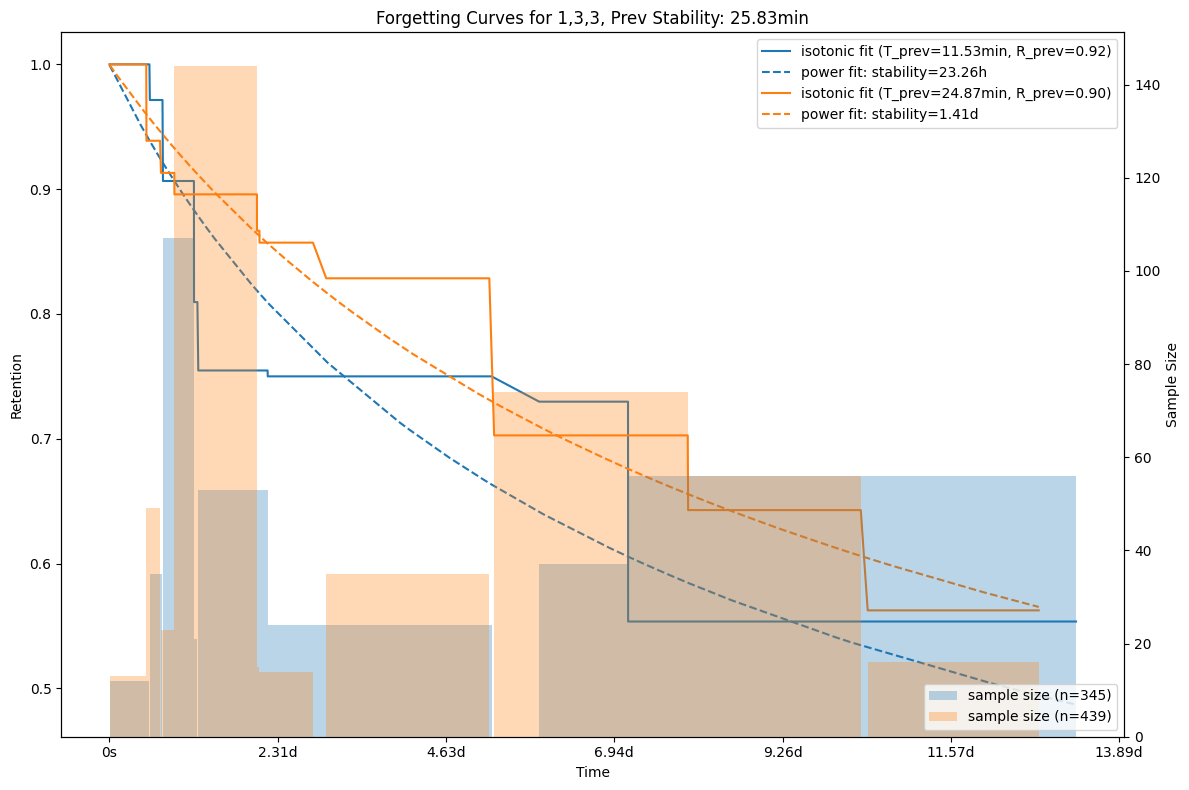

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


def format_time(x, pos=None):
    if x < 60:
        return f"{x:.0f}s"
    elif x < 3600:
        return f"{x/60:.2f}min"
    elif x < 86400:
        return f"{x/3600:.2f}h"
    else:
        return f"{x/86400:.2f}d"


def filter_data(data):
    Q1 = data["elapsed_seconds"].quantile(0.25)
    Q3 = data["elapsed_seconds"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data["elapsed_seconds"] >= lower_bound) & (data["elapsed_seconds"] <= upper_bound)]
    return data


r_history_list = ["1,1", "1,3", "3,3", "1,3,3"]


for r_history in r_history_list:

    fig, ax1 = plt.subplots(figsize=(12, 8))
    data = df[df["r_history"] == r_history][["elapsed_seconds", "y", "t_history"]]
    data = filter_data(data)

    if len(r_history) > 1:
        prev_data = df[df["r_history"] == r_history[:-2]]
        prev_data = filter_data(prev_data)
        prev_stability = fit_stability(
            prev_data["elapsed_seconds"], prev_data["y"], np.ones_like(prev_data["elapsed_seconds"])
        )
        median_ivl = prev_data["elapsed_seconds"].median()
        data["prev_interval"] = data["t_history"].apply(
            lambda x: [float(i) for i in x.split(",")][-1]
        )
        data_short = data[data["prev_interval"] <= median_ivl]
        data_long = data[data["prev_interval"] > median_ivl]
        median_short_ivl = prev_data[prev_data["elapsed_seconds"] <= median_ivl][
            "elapsed_seconds"
        ].median()
        median_long_ivl = prev_data[prev_data["elapsed_seconds"] > median_ivl][
            "elapsed_seconds"
        ].median()
        avg_short_retention = prev_data[prev_data["elapsed_seconds"] <= median_ivl]["y"].mean()
        avg_long_retention = prev_data[prev_data["elapsed_seconds"] > median_ivl]["y"].mean()

        datasets = [data_short, data_long]
        labels = [
            f"(T_prev={format_time(median_short_ivl)}, R_prev={avg_short_retention:.2f})",
            f"(T_prev={format_time(median_long_ivl)}, R_prev={avg_long_retention:.2f})",
        ]
    else:
        datasets = [data]
        labels = [r_history]

    ax2 = ax1.twinx()
    for idx, dataset in enumerate(datasets):
        x, y = dataset.sort_values(by="elapsed_seconds")[["elapsed_seconds", "y"]].values.T

        ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
        ir.fit(x, y)
        y_ir = ir.predict(x)

        s_seconds = fit_stability(x, y_ir, np.ones_like(x))
        y_pred = power_forgetting_curve(x, s_seconds)
        cnt = len(x)

        ax1.plot(x, y_ir, "-", label=f"isotonic fit {labels[idx]}", color=f"C{idx}")
        ax1.plot(
            x,
            y_pred,
            "--",
            label=f"power fit: stability={format_time(s_seconds)}",
            color=f"C{idx}",
        )

        unique_y_ir = np.unique(y_ir)
        segment_counts = []
        segment_x = []
        segment_widths = []
        for i in range(len(unique_y_ir)):
            mask = y_ir == unique_y_ir[i]
            segment_counts.append(np.sum(mask))
            segment_x.append(np.min(x[mask]))
            segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

        ax2.bar(
            segment_x,
            segment_counts,
            alpha=0.3,
            width=segment_widths,
            color=f"C{idx}",
            label=f"sample size (n={cnt})",
            align="edge",
        )

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Retention")
    ax2.set_ylabel("Sample Size")
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    ax1.set_title(
        f"Forgetting Curves for {r_history}, Prev Stability: {format_time(prev_stability)}"
    )

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))

    plt.tight_layout()
    plt.show()